# Performance test at Fornax 

In [1]:
%pip install --quiet lsdb

Note: you may need to restart the kernel to use updated packages.


In [2]:
import dask.array as da
import lsdb
import matplotlib.pyplot as plt
import numpy as np
from dask.distributed import Client

In [3]:
BUCKET = "irsa-mast-tike-spitzer-data"

GAIA_BASE = f"s3://{BUCKET}/data/GAIA/dr3/gaiasource/hipscat"
GAIA_OBJECT_PATH = f"{GAIA_BASE}/gaia-dr3-gaiasource-hipscat"
GAIA_OBJECT_MARGIN_PATH = f"{GAIA_BASE}/gaia-dr3-gaiasource-hipscat_margin_10arcsec"

ZTF_BASE = f"s3://{BUCKET}/data/ZTF/dr20"
ZTF_OBJECT_PATH = f"{ZTF_BASE}/objects/hipscat/ztf-dr20-objects-hipscat"
ZTF_OBJECT_MARGIN_PATH = f"{ZTF_BASE}/objects/hipscat/ztf-dr20-objects-hipscat_margin_10arcsec"
# ZTF_SOURCE_PATH = f"{ZTF_BASE}/lc/hipscat/ztf-dr20-lc-hipscat"

In [4]:
%%time

# This is loading Gaia catalog
gaia = lsdb.read_hipscat(
    GAIA_OBJECT_PATH,
    margin_cache=GAIA_OBJECT_MARGIN_PATH,
    columns=["ra", "dec", "phot_g_mean_mag", "phot_g_mean_flux_over_error"],
)#.cone_search(13, 57, radius_arcsec=30 * 3600)

# This is loading the full ZTF DR20 metadata catalog
ztf = lsdb.read_hipscat(
    ZTF_OBJECT_PATH,
    margin_cache=ZTF_OBJECT_MARGIN_PATH,
    columns=["ra", "dec", "filtercode", "meanmag"]
)

/opt/conda/envs/science_demo/lib/python3.11/site-packages/hipscat/io/file_io/file_io.py:292: UserWarning: point_map.fits file written in RING ordering, due to https://github.com/astronomy-commons/hipscat/issues/271. Converting to NESTED.
  warnings.warn(
/opt/conda/envs/science_demo/lib/python3.11/site-packages/hipscat/io/file_io/file_io.py:292: UserWarning: point_map.fits file written in RING ordering, due to https://github.com/astronomy-commons/hipscat/issues/271. Converting to NESTED.
  warnings.warn(


CPU times: user 1.08 s, sys: 83 ms, total: 1.16 s
Wall time: 3.05 s


In [5]:
%%time

catalog = (
    ztf
    .query("filtercode == 'zr' and meanmag.notna()")
    .crossmatch(
        gaia.query("phot_g_mean_flux_over_error > 5"),
        radius_arcsec=1,
        n_neighbors=1,
        suffixes=['_ztf', '_gaia'],
    )
)
color_G_zr = (catalog['phot_g_mean_mag_gaia'] - catalog['meanmag_ztf']).to_dask_array()

CPU times: user 2.99 s, sys: 16.1 ms, total: 3.01 s
Wall time: 3 s


/opt/conda/envs/science_demo/lib/python3.11/site-packages/dask/dataframe/core.py:3930: UserWarning: Dask currently has limited support for converting pandas extension dtypes to arrays. Converting float[pyarrow] to object dtype.
  warnings.warn(


In [6]:
%%time

hist, bins = da.histogram(color_G_zr, bins=np.linspace(-10, 10, 101))

with Client(n_workers=16) as client:
    display(client)
    hist = hist.compute()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 16,Total memory: 15.32 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41823,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 15.32 GiB
Comm: tcp://127.0.0.1:40613,Total threads: 1
Dashboard: http://127.0.0.1:45963/status,Memory: 0.96 GiB
Nanny: tcp://127.0.0.1:38821,


2024-06-27 12:48:40,934 - tornado.application - ERROR - Uncaught exception GET /individual-cluster-memory/ws (::1)
HTTPServerRequest(protocol='http', host='daskhub.fornaxdev.mysmce.com', method='GET', uri='/individual-cluster-memory/ws', version='HTTP/1.1', remote_ip='::1')
Traceback (most recent call last):
  File "/opt/conda/envs/science_demo/lib/python3.11/site-packages/tornado/web.py", line 1790, in _execute
    result = await result
             ^^^^^^^^^^^^
  File "/opt/conda/envs/science_demo/lib/python3.11/site-packages/tornado/websocket.py", line 273, in get
    await self.ws_connection.accept_connection(self)
  File "/opt/conda/envs/science_demo/lib/python3.11/site-packages/tornado/websocket.py", line 863, in accept_connection
    await self._accept_connection(handler)
  File "/opt/conda/envs/science_demo/lib/python3.11/site-packages/tornado/websocket.py", line 946, in _accept_connection
    await self._receive_frame_loop()
  File "/opt/conda/envs/science_demo/lib/python3.11/

CPU times: user 11min 32s, sys: 1min 57s, total: 13min 30s
Wall time: 1h 19min 37s


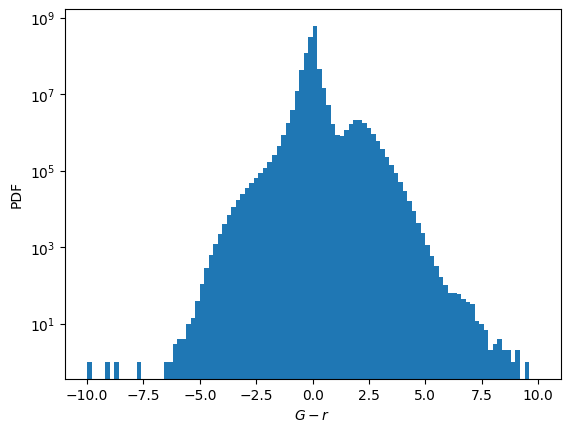

In [7]:
plt.bar(0.5 * (bins[:-1] + bins[1:]), hist, width=bins[1]-bins[0])
plt.yscale('log')
plt.xlabel('$G-r$')
plt.ylabel('PDF')
plt.savefig('hist.png')